In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [42]:
def evaluate_model(y_pred_train, y_pred_test, y_train, y_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    print("MAE train: ", mae_train)
    print("MAE test: ", mae_test)
    print("RMSE train: ", rmse_train)
    print("RMSE test: ", rmse_test)
    print("R2 train: ", r2_train)
    print("R2 test: ", r2_test)

In [43]:
def plot_predictions(y_test_real, y_pred_test_real):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_real, label="Real", color="blue")
    plt.plot(y_pred_test_real, label="Predicho", color="orange")
    plt.title("Predicciones vs. Valores Reales")
    plt.legend()
    plt.show()

In [44]:
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:i + n_steps])
        ys.append(y[i + n_steps])
    return np.array(Xs), np.array(ys)

In [45]:
df = pd.read_csv('../../data/pre_train/gspc.csv', index_col='date')
df.index = pd.to_datetime(df.index)
df = df.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

C:\Users\santi\AppData\Local\Temp\ipykernel_12220\2841548648.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


In [46]:
X = df.drop(columns=['close', 'log_close'])
y = df['log_close']

In [47]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1, 1))

In [48]:
time_steps = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [49]:
n_features = X_train.shape[2] 

model = Sequential([
    LSTM(30, return_sequences=False, input_shape=(time_steps, n_features)),
    Dropout(0.35),
    Dense(10, activation="relu"),
    Dense(1)
])

c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [51]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[reduce_lr])

Epoch 1/50


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.1892 - mae: 0.3752 - val_loss: 0.0143 - val_mae: 0.1119 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0273 - mae: 0.1299 - val_loss: 0.0047 - val_mae: 0.0586 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0139 - mae: 0.0935 - val_loss: 0.0047 - val_mae: 0.0598 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0120 - mae: 0.0860 - val_loss: 0.0019 - val_mae: 0.0346 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0099 - mae: 0.0794 - val_loss: 0.0066 - val_mae: 0.0772 - learning_rate: 0.0010
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0095 - mae: 0.0765 - val_loss: 0.0028 - val_mae: 0.0485 - learning_rate: 0.0010
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0078 - mae: 0.0692 - val_loss: 0.0018 - val_mae: 0.0368 - learning_rate: 0.0010
Epoch 8/50
30/30 ━━━━━━━

In [52]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [53]:
y_pred_train = y_pred_train.reshape(-1, 1)
y_pred_test = y_pred_test.reshape(-1, 1)

In [54]:
y_train_real = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_train_real = scaler_y.inverse_transform(y_pred_train)
y_pred_test_real = scaler_y.inverse_transform(y_pred_test)

In [55]:
evaluate_model(y_pred_train_real, y_pred_test_real, y_train_real, y_test_real)

MAE train:  0.021605051133248284
MAE test:  0.02410707281658501
RMSE train:  0.026078566025583106
RMSE test:  0.0271553796589516
R2 train:  0.9586919253033959
R2 test:  0.8121605028574534


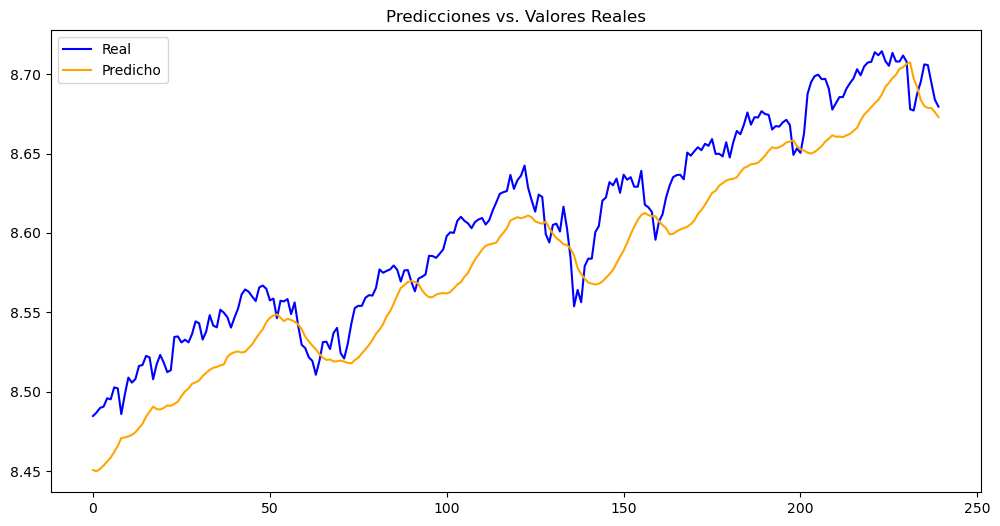

In [56]:
plot_predictions(y_test_real, y_pred_test_real)